# Libraries

## I/O

In [1]:
import os
from pprint import pprint
import pickle
from util_IO import (
    load_pickle_from_main_project_dir,
    EDA_dirs_structure,
    load_timeseries_df
)

## Analysis

In [2]:
import numpy as np
import pandas as pd
import missingno as msno

import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Settings

## Packages

In [3]:
# Set pandas to display a maximum of 300 columns
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 1000)

## Parameters

### Load metadata from previous step (*1-DataAggregation.ipynb*)

In [4]:
aggr_parameters_dict, camels_gb_use_case_dir = load_pickle_from_main_project_dir(
    'aggr_parameters_dict.pkl'
)

# # Print imported variable
pprint(aggr_parameters_dict)

{'attributes': {'aggregations': {'fundamental': {'chalk_streams_df': ['chalk_stream_flag'],
                                                 'climatic_attributes_df': [],
                                                 'humaninfluence_attributes_df': ['surfacewater_abs',
                                                                                  'groundwater_abs',
                                                                                  'discharges',
                                                                                  'num_reservoir',
                                                                                  'reservoir_cap'],
                                                 'hydrogeology_attributes_df': [],
                                                 'hydrologic_attributes_df': ['baseflow_index'],
                                                 'hydrometry_attributes_df': ['bankfull_flow'],
                                                 'landc

### Retrieve variables in use

In [5]:
camels_gb_data_timeseries_aggr_dir = aggr_parameters_dict['camels_gb_data_timeseries_aggr_dir']
date_field = aggr_parameters_dict["timeseries"]["date_field"]
label_field = aggr_parameters_dict["timeseries"]['label_field']

In [6]:
# Loading EDA directories structure
camels_gb_eda_dir, camels_gb_eda_attributes_dir, camels_gb_eda_timeseries_dir = EDA_dirs_structure()

print(f"Main directory for EDA:\t\t{camels_gb_eda_dir}")
print(f"EDA directory for time series:\t{camels_gb_eda_timeseries_dir}")

Main directory for EDA:		/home/jupyter/RDMAI_Sensing/flow-derivation-camels-gb/resources/EDA
EDA directory for time series:	/home/jupyter/RDMAI_Sensing/flow-derivation-camels-gb/resources/EDA/timeseries


### EDA style

In [7]:
timeseries_save_files_flag = False

# Timeseries

## Retrieve aggregated file

In [8]:
timeseries_df = load_timeseries_df(
    camels_gb_data_timeseries_aggr_dir,
    "timeseries.csv",
    date_field
)

display(timeseries_df.head(3))

,catchmentID,date,precipitation,pet,temperature,discharge_spec,discharge_vol_files,peti,humidity,shortwave_rad,longwave_rad,windspeed,discharge_vol,date_diff,date_consecutive_day,date_group
0,101002,1997-03-01,0.26,0.70,8.31,0.90,0.32,0.93,6.11,73.68,320.09,6.23,0.319,0.0,False,00
1,101002,1997-03-02,0.10,1.42,9.55,0.89,0.31,1.68,5.64,89.11,315.49,6.51,0.314,1.0,False,00
2,101002,1997-03-03,24.15,0.53,5.84,1.12,0.40,0.65,4.98,51.62,320.09,2.75,0.397,1.0,False,00


## EDA

#### Define plotting function

In [9]:
def timeseries_display(
    group,
    curr_catchmentID,
    max_observations_per_plot,
    action
):

    # Initializations for `save`` mode
    if action == 'save':
        save_directory = (
            os.path.join(
                    camels_gb_eda_timeseries_dir,
                    curr_catchmentID
                )
        )
        os.makedirs(save_directory, exist_ok=True)

        print(curr_catchmentID, end=' ')
    
    # Date conversion
    group[date_field] = pd.to_datetime(group[date_field])
    
    # Calculate the number of plots needed
    num_plots = math.ceil(len(group) / max_observations_per_plot)

    # Create subplots for each chunk of data
    for i in range(num_plots):
        start_idx = i * max_observations_per_plot + 1 * bool(i)
        end_idx = (i + 1) * max_observations_per_plot
        chunk_df = group.iloc[start_idx:end_idx].copy()

        if chunk_df.shape[0] == 0:
            continue

        # Create a figure with A4 size (8.27 x 11.69 inches)
        fig, axes = plt.subplots(7, 1, figsize=(8.27, 11.69), sharex=True)

        # Plot each variable in a separate subplot
        sns.lineplot(data=chunk_df, x=date_field, y='discharge_vol', ax=axes[0], color='darkred')
        sns.lineplot(data=chunk_df, x=date_field, y='precipitation', ax=axes[1], color='blue')
        sns.lineplot(data=chunk_df, x=date_field, y='temperature', ax=axes[2], color='red')
        sns.lineplot(data=chunk_df, x=date_field, y='humidity', ax=axes[3], color='red')
        sns.lineplot(data=chunk_df, x=date_field, y='shortwave_rad', ax=axes[4], color='orange')
        sns.lineplot(data=chunk_df, x=date_field, y='longwave_rad', ax=axes[5], color='orange')
        sns.lineplot(data=chunk_df, x=date_field, y='windspeed', ax=axes[6], color='lightblue')

        # Add vertical yellow lines on every 1st of October
        for ax in axes:
            for year in range(chunk_df[date_field].dt.year.min(), chunk_df[date_field].dt.year.max() + 1):
                ax.axvline(pd.Timestamp(f'{year}-10-01'), color='#FFD700', linestyle='--', linewidth=1)

        # Set light grey grid lines for each subplot
        for ax in axes:
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

        # Set x-axis limits to match chunk_df date range
        for ax in axes:
            ax.set_xlim(chunk_df[date_field].min(), chunk_df[date_field].max())

        # Format x-axis labels as MMM-YY
        for ax in axes:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

        # Remove space between subplots
        plt.subplots_adjust(hspace=0)

        # Remove x-axis label from the bottom subplot
        axes[6].set_xlabel('')

        # Set base
        base = f"{curr_catchmentID} - "
        title = f"{base}{i+1}/{num_plots}"

        # Set the overall title for the figure
        fig.suptitle(
            title,
            fontsize=14,
            y=0.93
        )

        # Adjust layout and save the figure to a file
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save..
        if action == 'save':

            file_name = f"{base}{i+1:02}_{num_plots}".replace("/", "_")

            #..save..
            plt.savefig(
                os.path.join(
                    save_directory,
                    file_name
                ),
                dpi=300
            )

            # Close the figure to avoid RuntimeWarning
            plt.close(fig)
            
        else:
            #..or show
            plt.show()

#### Save PNGs

In [10]:
if timeseries_save_files_flag == True:

    # Define the maximum number of timesteps per plot
    max_observations_per_plot = 400

    # Create the profiles for each `catchmentID`
    for catchment_id, group in timeseries_df.groupby("catchmentID"):
        
        timeseries_display(
            group,
            catchment_id,
            max_observations_per_plot,
            'save'
        )

#### In-line plotting

In [11]:
# Change to `True` if you want to perform in-line plotting
if False:
    max_observations_per_plot = 400
    catchmentID = '101002'

    group = timeseries_df[timeseries_df['catchmentID']==catchmentID].copy()

    timeseries_display(
        group,
        catchmentID,
        max_observations_per_plot,
        'show'
    )

### Length of timeseries

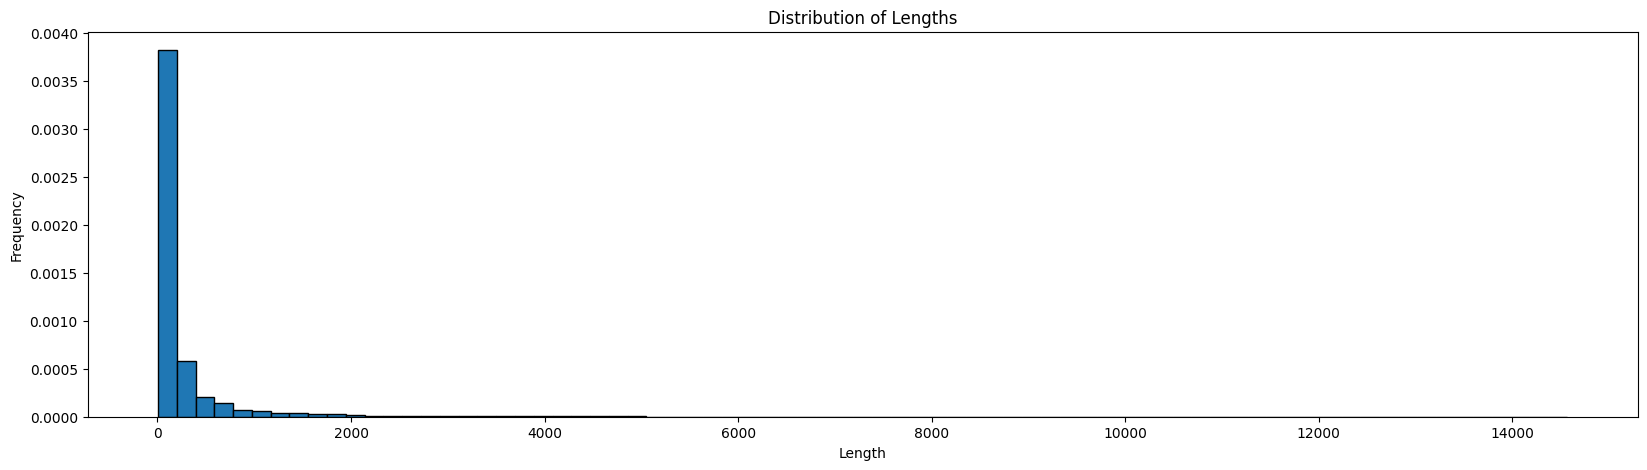

In [12]:
# # Read dictionary
catchmentID_time_ranges_dict, _ = load_pickle_from_main_project_dir('catchmentID_time_ranges_dict.pkl')

# Dumping all the lengths into a list
lengths = [sub_dict['length'] for sub_dict in catchmentID_time_ranges_dict.values() if 'length' in sub_dict]
                   
# Plotting the distribution
plt.figure(figsize=(20, 5))
plt.hist(lengths, bins=75, edgecolor='black', density=True)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Lengths')
plt.show()

### Correlation

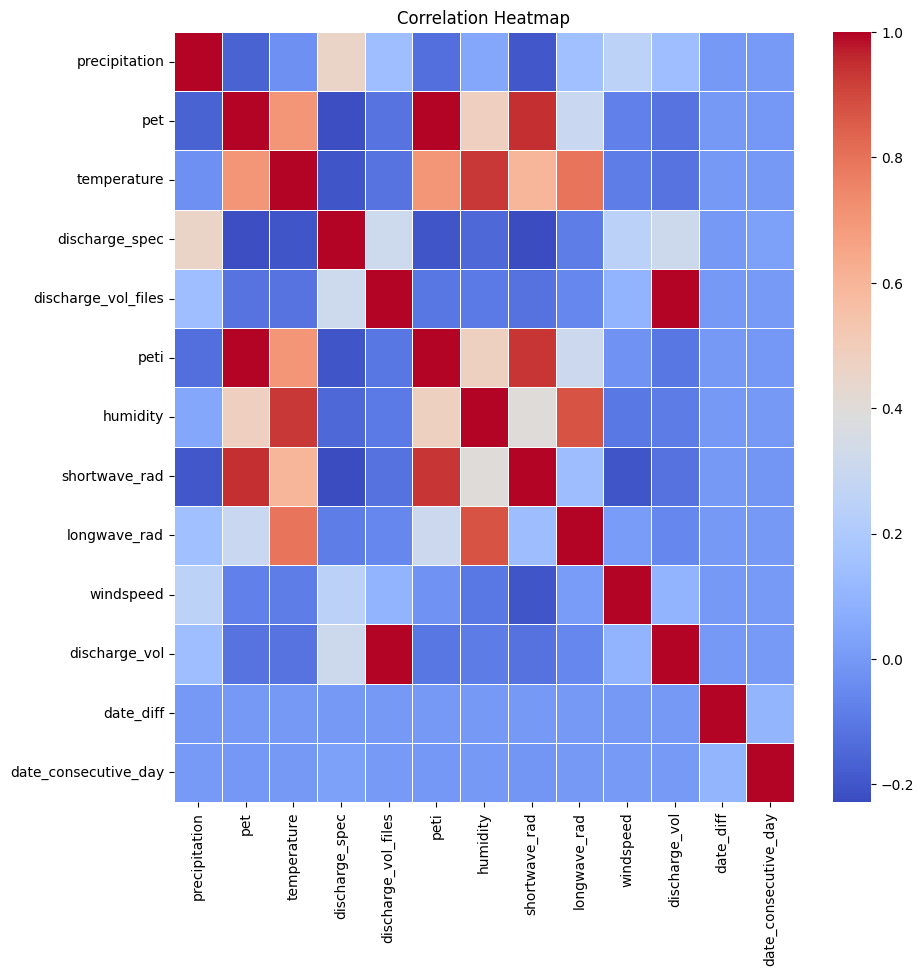

In [13]:
# Calculate the correlation matrix
corr_matrix = timeseries_df.select_dtypes(exclude=['object']).corr()

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Correlation Heatmap')
plt.show()

### Max number of consecutive rainy days

In [14]:
# Change to `True` if you want to calculate max number of consecutive rainy days
if False:
    rain_measure_df = timeseries_df[['catchmentID', date_field, 'precipitation']].copy()

    def max_consecutive_rainy_days(group):
        group['rained'] = group['precipitation'] > 0
        group['group'] = (group['rained'] != group['rained'].shift()).cumsum()
        rainy_streaks = group[group['rained']].groupby('group').size()
        return rainy_streaks.max() if not rainy_streaks.empty else 0

    max_rainy_days_per_catchment = (
        rain_measure_df
            .groupby('catchmentID')
            .apply(max_consecutive_rainy_days)
            .reset_index(name='max_consecutive_rainy_days')
            .sort_values(
                'max_consecutive_rainy_days',
                ascending=False
            )
    )

    display(max_rainy_days_per_catchment.head(10))

### Missing values

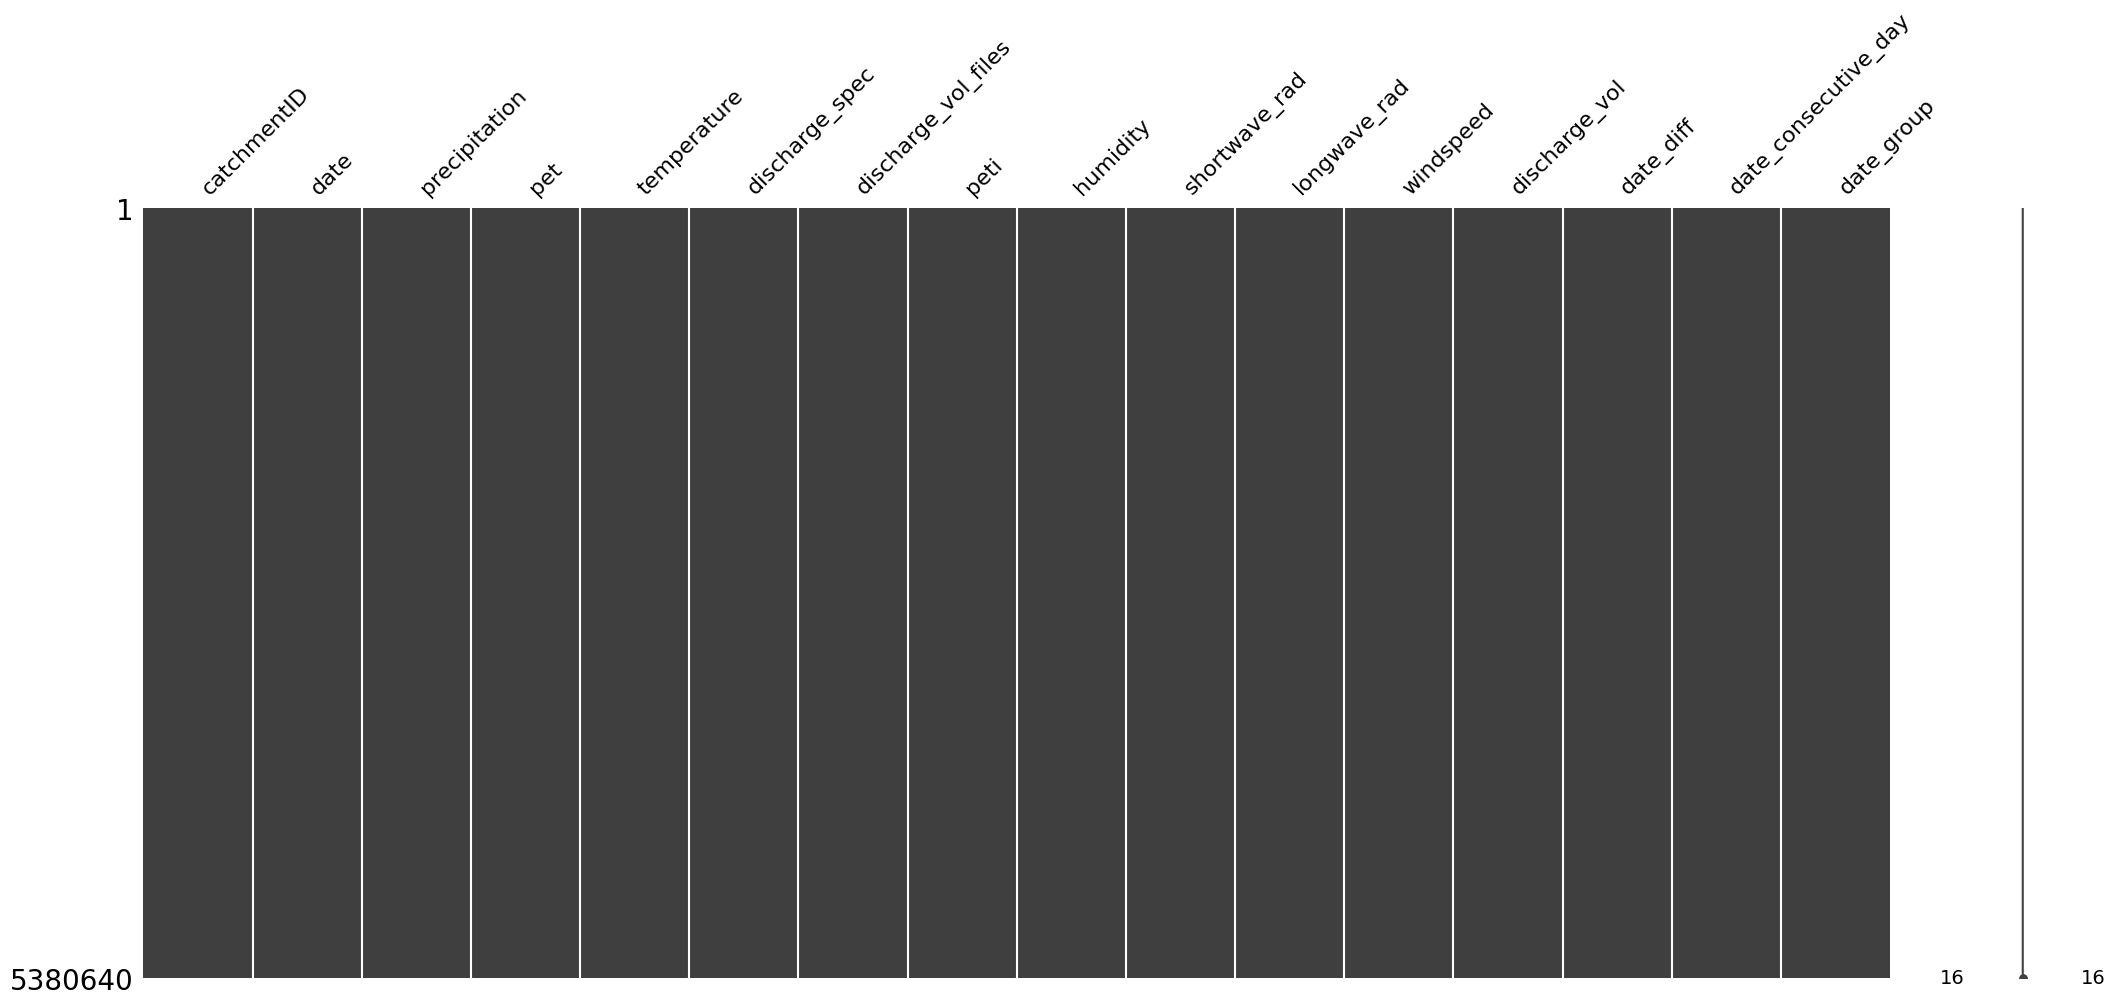

In [15]:
msno.matrix(timeseries_df)
plt.show()

### Target statistics

#### Standard statistics on distribution

In [16]:
# Change to `True` if you want to calculate target' standard metrics
if False:    
    # Group by 'catchment_id' and calculate the required statistics
    timeseries_grouped_df = timeseries_df.groupby('catchmentID')[label_field].agg(
        max_value=('max'),
        p90=lambda x: np.percentile(x, 90).item(),
        p75=lambda x: np.percentile(x, 75).item(),
        p50=lambda x: np.percentile(x, 50).item(),
        p25=lambda x: np.percentile(x, 25).item(),
        p12=lambda x: np.percentile(x, 12).item(),
        min_value=('min')
    )

    # Order by extremes
    timeseries_grouped_df.sort_values(
        by=timeseries_grouped_df.columns.to_list(),
        ascending=False,
        inplace=True
    )

    # Display the resulting DataFrame
    display(timeseries_grouped_df)

#### Zeros count

In [17]:
discharge_vol = pd.DataFrame(
    timeseries_df[f"{label_field}"]
)

discharge_vol['isZero'] = discharge_vol[f"{label_field}"] == 0

discharge_vol['isZero'].value_counts(normalize=True)

isZero
False    0.998029
True     0.001971
Name: proportion, dtype: float64

`discharge_vol`'s comparison analysis

In [18]:
# Calculate series  differences between api and files
discharge_vol_diff = (
    timeseries_df[f"{label_field}_files"] - timeseries_df[f"{label_field}"]
)

# _____________________
# Error threshold quote

# Set a threshold
threshold = 0.02

# Calculate quote
quote = (
    (
        discharge_vol_diff[
            discharge_vol_diff > threshold
        ]
    )
    .shape[0]
        / discharge_vol_diff.shape[0]
)

# Calculate the quote of differences greater than the threshold
print(f"Quote of observations with {label_field}'s difference greater than {threshold:.0%}: {quote:.0%}")


# ______________
# Zeros counting

# Calculate quote
quote = (
    (
        discharge_vol_diff[
            discharge_vol_diff == 0
        ]
    )
    .shape[0]
        / discharge_vol_diff.shape[0]
)

# Calculate the quote of differences greater than the threshold
print(f"Quote of observations equal to ZERO: {quote:.0%}")

Quote of observations with discharge_vol's difference greater than 2%: 8%
Quote of observations equal to ZERO: 13%


### Target graphs

#### Histograms function definition

In [19]:
def target_hist_get(
    threshold
):
    # Create a figure with two subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    plot_df_filtered = timeseries_df[timeseries_df[label_field]>=threshold].copy()
    plot_df_filtered[f"log1p_{label_field}"] = np.log1p(plot_df_filtered[label_field])

    # Plot on the left
    plot_df_filtered[label_field].plot(kind='hist', bins=100, density=True, ax=axes[0], title=label_field)
    axes[0].set_ylabel('Frequency')
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Plot log1p of `label_field` on the right
    plot_df_filtered[f"log1p_{label_field}"].plot(kind='hist', bins=100, density=True, ax=axes[1], title=f"log1p_{label_field}")
    axes[1].set_ylabel('')
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Show the plot
    plt.tight_layout()
    plt.show()

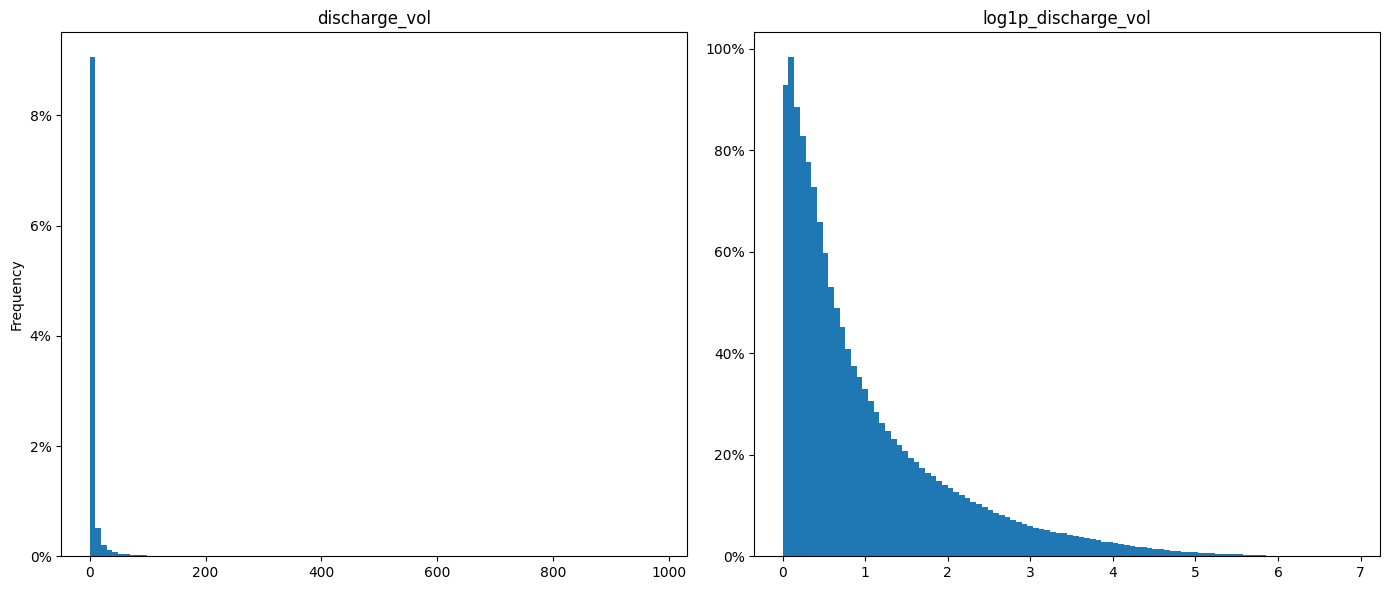

In [20]:
target_hist_get(0)

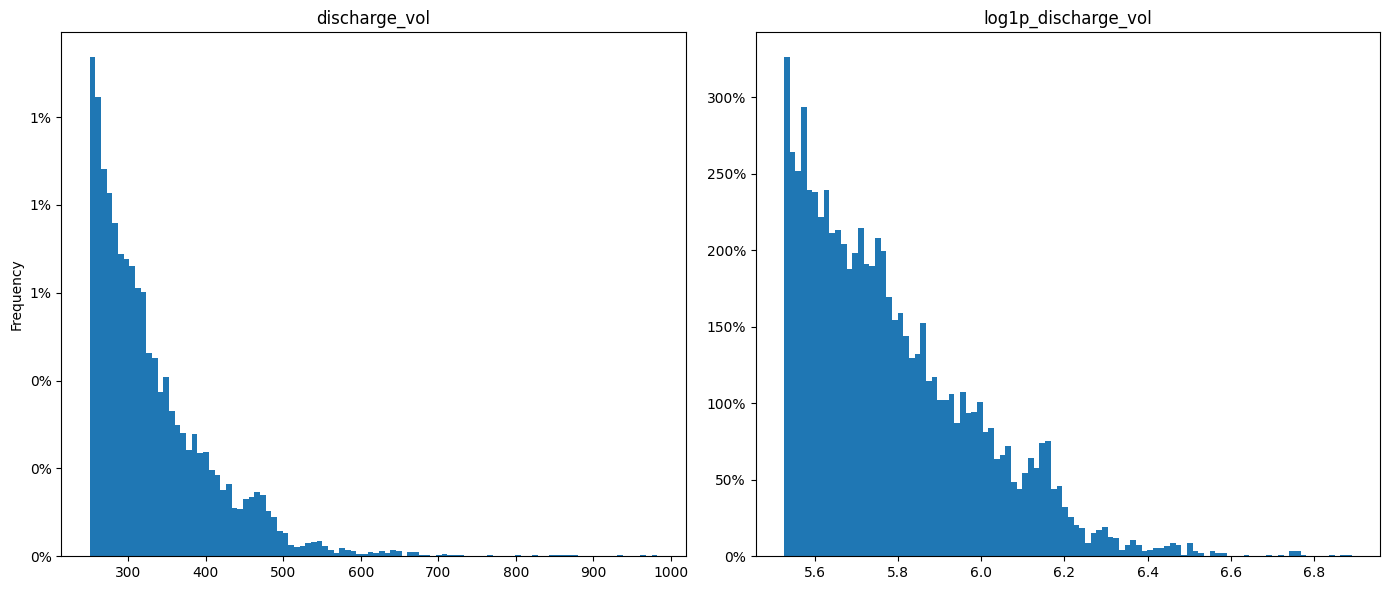

In [21]:
target_hist_get(250)

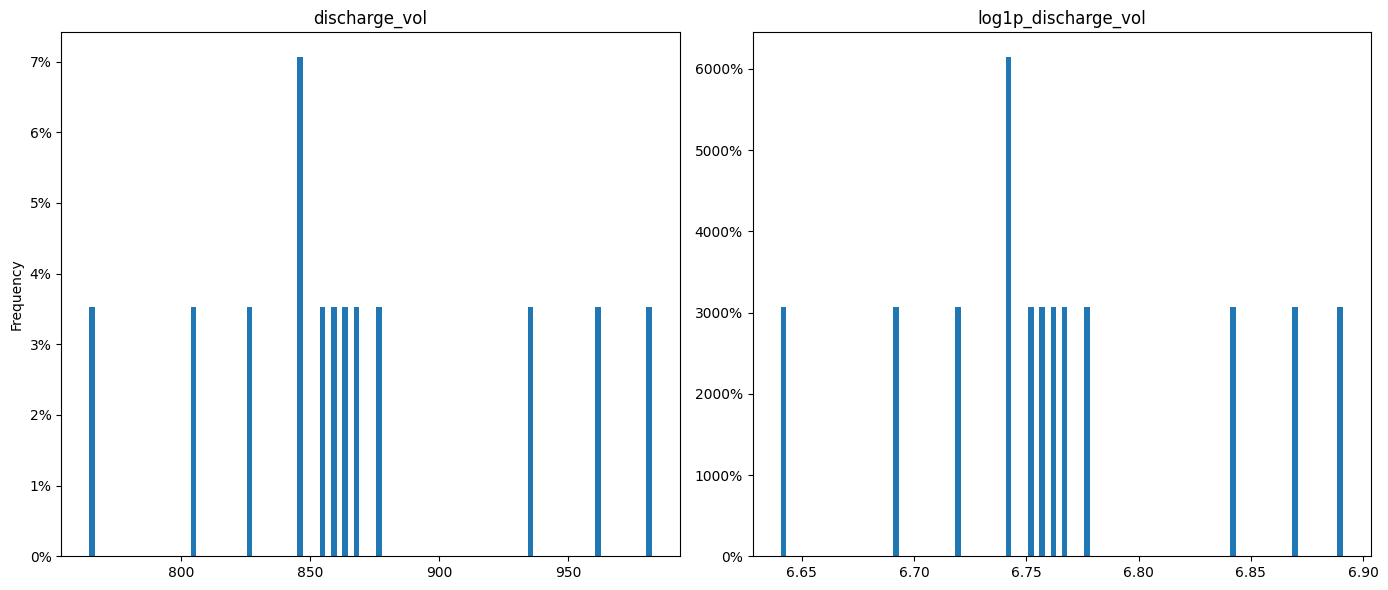

In [22]:
target_hist_get(750)